In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tslearn.metrics import dtw
from sklearn.model_selection import train_test_split, GridSearchCV

import time

# Data

Data was found from Kaggle at https://www.kaggle.com/code/mineshjethva/ecg-anomaly-detection.

Alternate link to the data: http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv.

The data contains 5000 time series of ECG data, labeled as normal or abnormal.

# Objective

Train a model to classify new ECG waveform as normal or abnormal. Column 140 identifies the class: 0 for Normal, 1 for Abnormal.

# Exploratory Data Analysis

In [2]:
#df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df = pd.read_csv('data/ecg.csv', header=None);

In [17]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


(4998, 141)

In [11]:
# Separate classes for EDA visualization
df_0 = df[df[140] == 0].iloc[:, :-1]     # 2070
df_1 = df[df[140] == 1].iloc[:, :-1]     # 2919

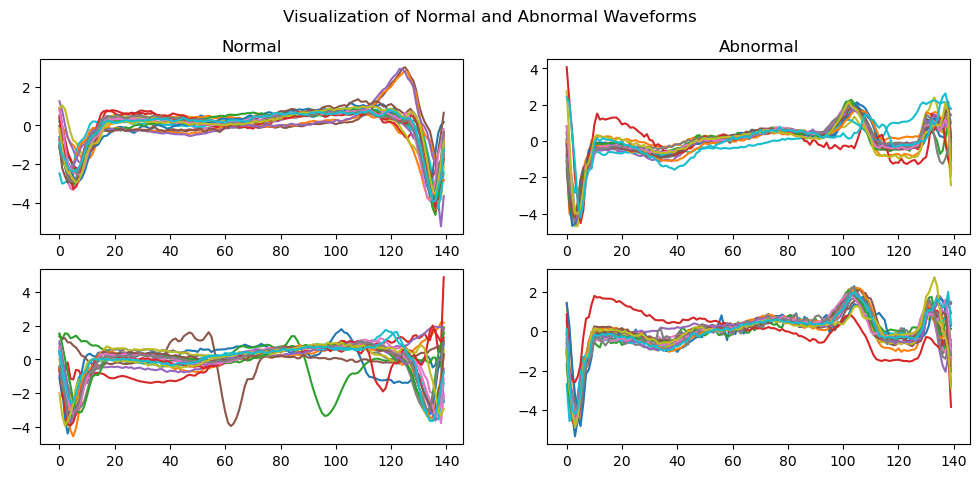

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle('Visualization of Normal and Abnormal Waveforms')
df_0.iloc[0:20,:].T.plot(kind='line', legend=False, ax=axes[0,0])
axes[0,0].set_title('Normal')
df_1.iloc[0:20,:].T.plot(kind='line', legend=False, ax=axes[0,1])
axes[0,1].set_title('Abnormal')
df_0.iloc[1000:1020,:].T.plot(kind='line', legend=False, ax=axes[1,0])
df_1.iloc[1000:1020,:].T.plot(kind='line', legend=False, ax=axes[1,1])
#df.iloc[130:135,:].T.mean(axis=1).plot(kind='line')
plt.savefig('images/visualization1.png')

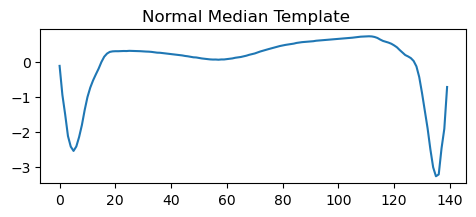

In [12]:
normal_median_template = df_0.iloc[:,:].median()
normal_median_template.plot(kind='line', figsize=(5.5,2))
plt.suptitle('Normal Median Template')
plt.savefig('images/normal-median-template.png')

## Observations
* Both the Normal and Abnormal waveforms present in a few distinct forms that seem legitimate, but some look like they were sliced improperly.
    * For example, in the lower left pane (1,0) above, a brown and green waveform show shapes in the middle that appear congruent with the shapes near the beginning in the majority of waveforms, leading to the supposition that those middle-located shapes should have been located near the beginning and were sliced incorrectly.
    * 🚩These badly sliced data would interfere, particularly with the Normal labeled data, and should be removed.
* Some waveforms appear to carry a trend, and may warrant detrending, if possible.
    * 💡This might be done by fitting a linear trend line for each waveform and subtracting it out. But it looks like this could easily add more error than it removes owing to the varying shapes and their amplitudes.

💡 Look into Matched Filter (like a point-by-point dot product). It maximizes SNR. It looks like cross-correlation.


## Data Cleaning

Locate bad data by sorting waveforms by similarity and inspecting the least similar.

In [13]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [78]:
def similarity(a, b, method='xcor'):
    """ Lower number is more similar """
    
    if method == 'xcor':
        return 1 / np.corrcoef(a, b)[0, 1]
    elif method == 'mse':
        return mean_squared_error(a, b)

# Single input, single output function that can be used as an argument to DataFrame.apply
def similarity_vs_template(a):
    return similarity(a, normal_median_template, 'mse')


In [15]:
def plot_least_similar(X, label: object):
    similarities = X.apply(similarity_vs_template, axis=1)
    least_similar_idx = similarities.sort_values(ascending=False).index.tolist()

    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle('Visualization of Lowest Similarity Waveforms: ' + label)
    axes = axes.flatten()

    num_wfm = 25
    for plt_i in range(len(axes)):
        s = slice(plt_i * num_wfm, (plt_i + 1) * num_wfm)
        X.loc[least_similar_idx[s]].T.plot(kind='line', legend=False, ax=axes[plt_i])
        axes[plt_i].set_title(f'{s.start} to {s.stop-1}')
    plt.tight_layout()

    return least_similar_idx


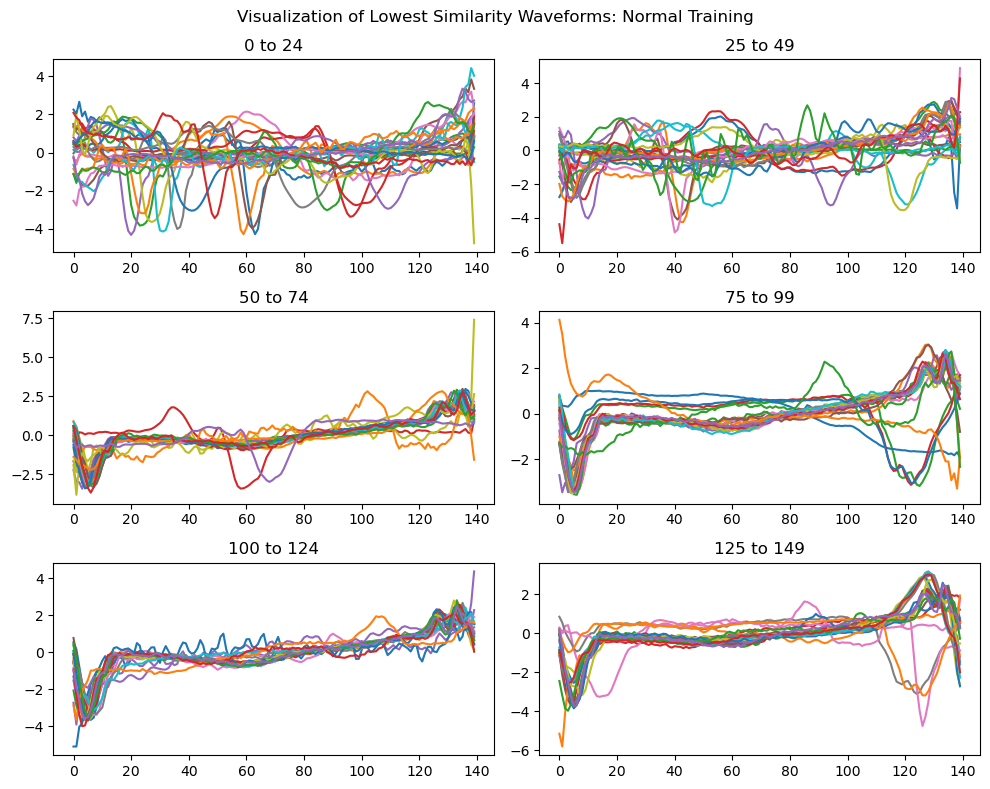

In [16]:
least_similar_idx = plot_least_similar(df_0, 'Normal Training')

Observation: The first hundred waveforms look like they contain false starts.

The process should be repeated on the whole data set.

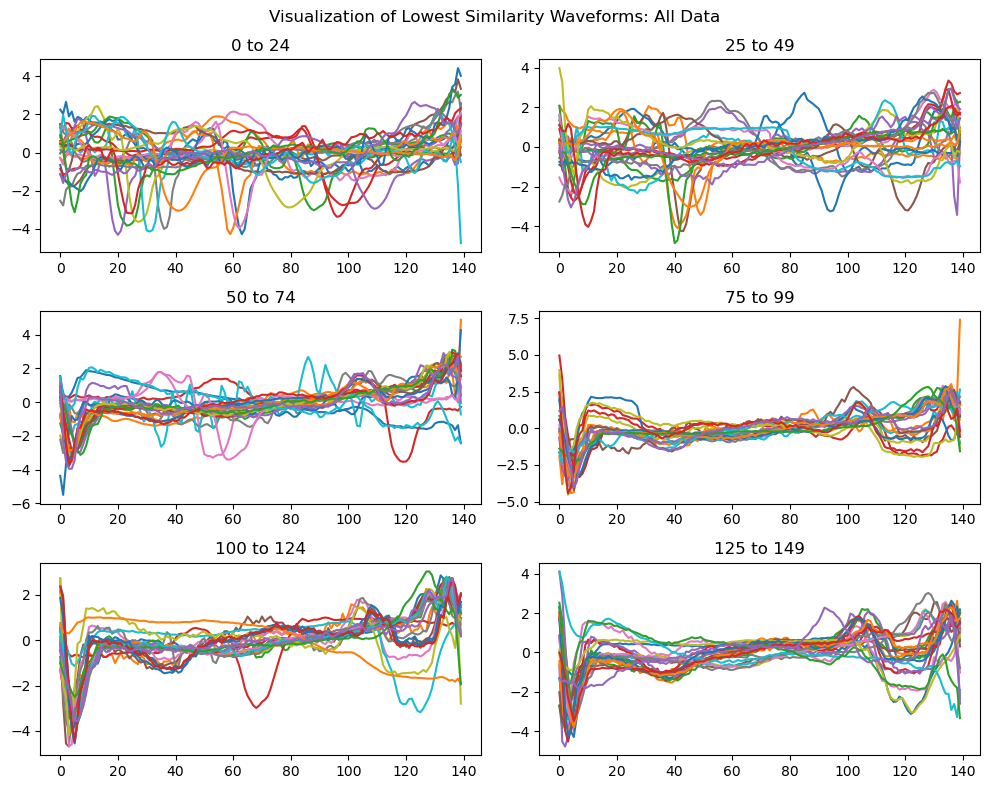

In [17]:
least_similar_idx = plot_least_similar(X, 'All Data')

In [18]:
# The shapes supposed to be false starts appear constrained to the first 125 samples.
X_clean = X.drop(least_similar_idx[0:124])
y_clean = y.drop(least_similar_idx[0:124])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, stratify=y_clean)

In [21]:
# Cleanup workspace
del df_0, df_1, least_similar_idx, X, y

# Model Evaluation

The following models will be evaluated on accuracy, precision, recall, and a subjective score that accounts for asymmetric cost of false negatives.

Let's say the cost of False Negatives is 3 times higher than the cost of False Positives.
That is, Recall is 3 times more valuable than Precision.
The Subjective metric is therefore the weighted average:

$subjective = \frac{1}{4} \cdot accuracy + \frac{3}{4} \cdot precision$



In [22]:
# Utility to record model results for final comparison
results_df = pd.DataFrame(columns = ['model_name', 'train_time', 'train_acc', 'train_subjective', 'test_acc', 'test_subjective'])

def reset_results():
    global results_df
    results_df = pd.DataFrame(columns = ['model_name', 'train_time', 'train_acc', 'train_subjective', 'test_acc', 'test_subjective'])

def record_results(model_name, train_time, train_acc, train_subj, test_acc, test_subj):
    results_df.loc[len(results_df)] = {
        'model_name': model_name,
        'train_time': train_time,
        'train_acc': train_acc,
        'train_subjective': train_subj,
        'test_acc': test_acc,
        'test_subjective': test_subj
}

## Baseline Statistical Model: Similarity Threshold vs Class Template

Before feature engineering and ML models are trained, a statistical baseline will be run.

The statistical baseline approach:
1. Compute a baseline template as a point-by-point median filter of the Normal class (y==0) waveforms in the Training set.
2. For each sample, compute the similarity to the template.
3. Find a similarity threshold value that optimizes a performance metric.

In [23]:
# Make baseline template from Training data
baseline_template = X_train[y_train == 0].iloc[:,:].median()

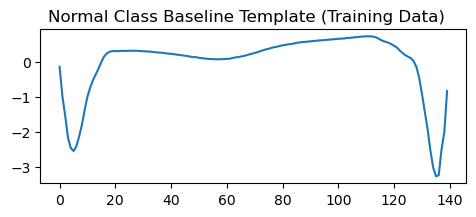

In [24]:
# Plot the baseline Training template
baseline_template.plot(kind='line', figsize=(5.5,2))
plt.suptitle("Normal Class Baseline Template (Training Data)")
plt.savefig('images/baseline-normal-template-train.png')

In [59]:
def baseline_model_fit_score(template, X, y, label, similarity_strat='mse'):
    
    t0 = time.time()

    similarities = X.apply(lambda wfm: similarity(wfm, template, similarity_strat), axis=1)

    # Grid search
    t1 = time.time()
    th_grid = np.linspace(similarities.min(), similarities.quantile(0.95), 50)
    acc = []
    precision = []
    recall = []
    for th in th_grid:
        preds = np.where(similarities < th, 0, 1)
        acc.append(accuracy_score(y, preds))
        precision.append(precision_score(y, preds))
        recall.append(recall_score(y, preds))

    train_time = time.time() - t0

    # Calculate score
    score_df = pd.DataFrame({'threshold': th_grid, 'accuracy': acc, 'precision': precision, 'recall': recall})
    score_df['subjective'] = score_df['recall'] * (3/4) + score_df['precision'] * (1/4)
    best_idx = np.argmax(score_df['subjective'])
    best_th = score_df.loc[best_idx, 'threshold']
    best_subjective = score_df.loc[best_idx, 'subjective']
    best_accuracy = score_df.loc[best_idx, 'accuracy']

    # Plots ...
    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    fig.suptitle('Baseline Model Score: ' + label + ' (using ' + similarity_strat + ')')

    # Plot 1: scores vs threshold
    score_df.plot(kind='line', x='threshold', y=['accuracy', 'precision', 'recall', 'subjective'], ax=axes[0])
    axes[0].set_title('Scores vs Threshold')    
    axes[0].axvline(best_th, 0, 1, linestyle='--', color=(0,0,0), label=f'th={best_th}')
    
    # Plot 2: precision vs recall
    score_df.plot(kind='line', x='recall', y='precision', ax=axes[1])
    axes[1].set_title('Precision vs Recall')

    # Plot 3: confusion matrix
    preds = np.where(similarities < best_th, 0, 1)
    ConfusionMatrixDisplay.from_predictions(y, preds, labels=[0, 1], ax=axes[2])

    plt.savefig('images/baseline-score-' + label + '-' + similarity_strat + '.png')

    print(f'Best Train threshold :\t{best_th.round(3)}')
    print(f'Best Train accuracy  :\t{best_accuracy.round(3)}')
    print(f'Best Train subjective:\t{best_subjective.round(3)}')

    return (train_time, best_th, best_subjective, best_accuracy)

Best Train threshold :	0.482
Best Train accuracy  :	0.931
Best Train subjective:	0.972


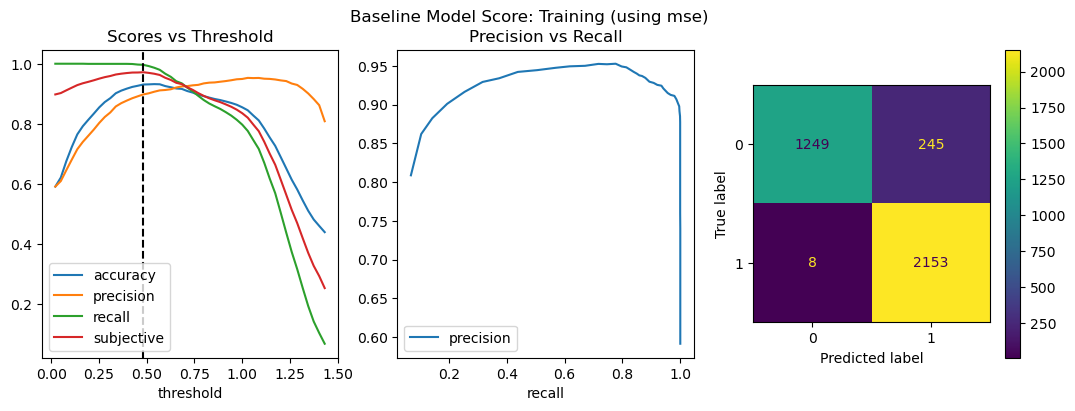

In [60]:
similarity_strat = 'mse'
train_time, baseline_th_train, baseline_subjective_train, baseline_accuracy_train = baseline_model_fit_score(
    baseline_template, X_train, y_train, 'Training', similarity_strat)

In [61]:
def baseline_model_predict_score(template, X, y, th_model, label, similarity_strat='mse'):
    similarities = X.apply(lambda wfm: similarity(wfm, template, similarity_strat), axis=1)

    # Grid sweep (for the purpose of creating plots)
    th_grid = np.linspace(similarities.min(), similarities.quantile(0.95), 50)
    acc = []
    precision = []
    recall = []
    for th in th_grid:
        preds = np.where(similarities < th, 0, 1)
        acc.append(accuracy_score(y, preds))
        precision.append(precision_score(y, preds))
        recall.append(recall_score(y, preds))

    # Calculate score for plot
    score_df = pd.DataFrame({'threshold': th_grid, 'accuracy': acc, 'precision': precision, 'recall': recall})
    score_df['subjective'] = score_df['recall'] * (3/4) + score_df['precision'] * (1/4)
    
    # Calculate score for model threshold used
    preds = np.where(similarities < th_model, 0, 1)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    subjective = recall * (3/4) + precision * (1/4)
    accuracy = accuracy_score(y, preds)

    # Plots ...
    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    fig.suptitle('Baseline Model Score: ' + label + ' (using ' + similarity_strat + ')')

    # Plot 1: scores vs threshold
    score_df.plot(kind='line', x='threshold', y=['accuracy', 'precision', 'recall', 'subjective'], ax=axes[0])
    axes[0].set_title('Scores vs Threshold')    
    axes[0].axvline(th_model, 0, 1, linestyle='--', color=(0,0,0), label=f'th={th_model}')
    
    # Plot 2: precision vs recall
    score_df.plot(kind='line', x='recall', y='precision', ax=axes[1])
    axes[1].set_title('Precision vs Recall')

    # Plot 3: confusion matrix
    preds = np.where(similarities < th_model, 0, 1)
    ConfusionMatrixDisplay.from_predictions(y, preds, labels=[0, 1], ax=axes[2])

    plt.savefig('images/baseline-score-' + label + '-' + similarity_strat + '.png')

    print(f'Test threshold :\t{th_model.round(3)}')
    print(f'Test accuracy  :\t{round(accuracy, 3)}')
    print(f'Test subjective:\t{subjective.round(3)}')

    return (subjective, accuracy)

In [74]:
def run_baseline(baseline_template, X_train, y_train, X_test, y_test, similarity_strat = 'mse'):
    
    train_time, baseline_th_train, baseline_subjective_train, baseline_accuracy_train = baseline_model_fit_score(
        baseline_template, X_train, y_train, 'Training', similarity_strat)
    
    baseline_subjective_test, baseline_accuracy_test = baseline_model_predict_score(
        baseline_template, X_test, y_test, baseline_th_train, 'Test', similarity_strat)
    
    record_results('Baseline ' + similarity_strat, train_time, baseline_accuracy_train, baseline_subjective_train, baseline_accuracy_test, baseline_subjective_test)

Best Train threshold :	0.482
Best Train accuracy  :	0.931
Best Train subjective:	0.972
Test threshold :	0.482
Test accuracy  :	0.936
Test subjective:	0.974


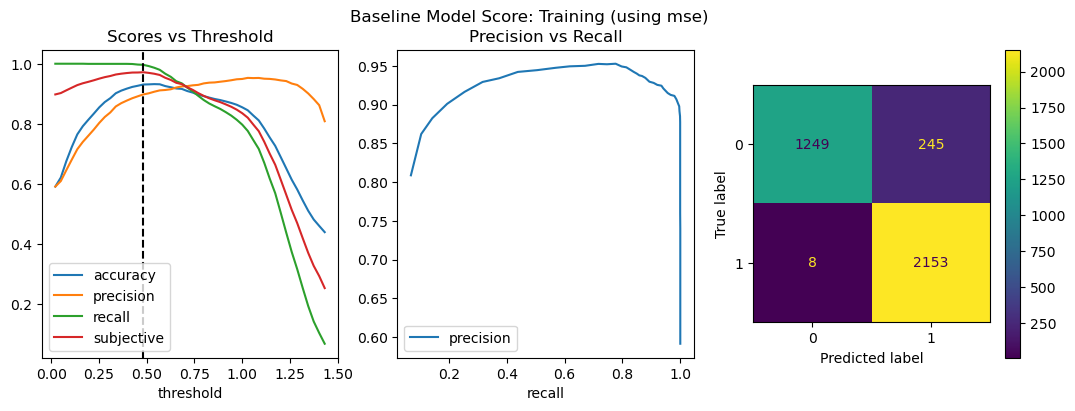

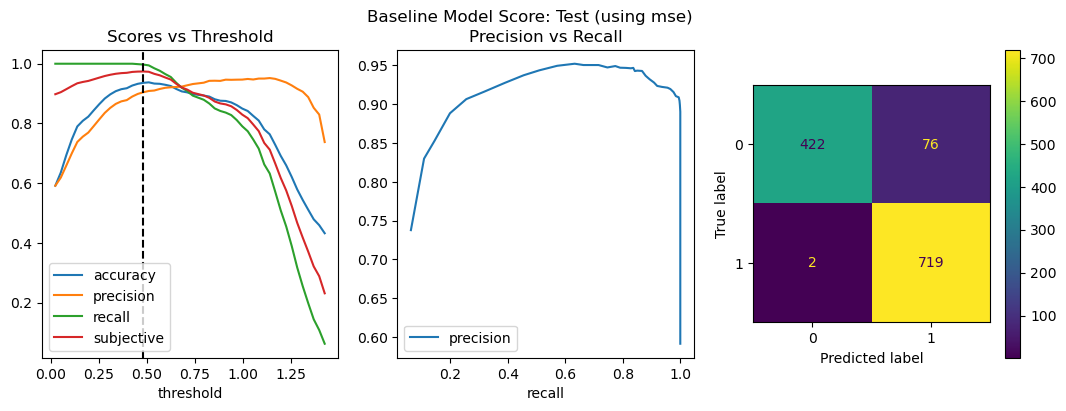

In [76]:
run_baseline(baseline_template, X_train, y_train, X_test, y_test, similarity_strat='mse')

Best Train threshold :	1.317
Best Train accuracy  :	0.926
Best Train subjective:	0.972
Test threshold :	1.317
Test accuracy  :	0.93
Test subjective:	0.974


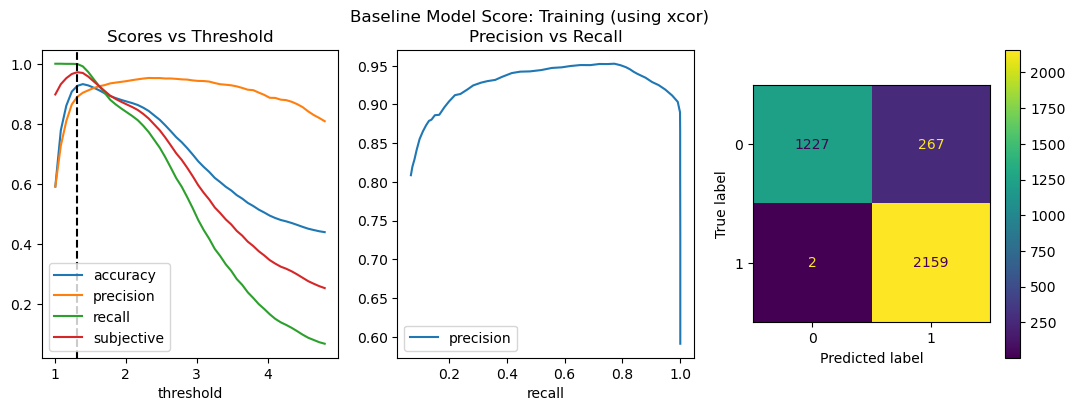

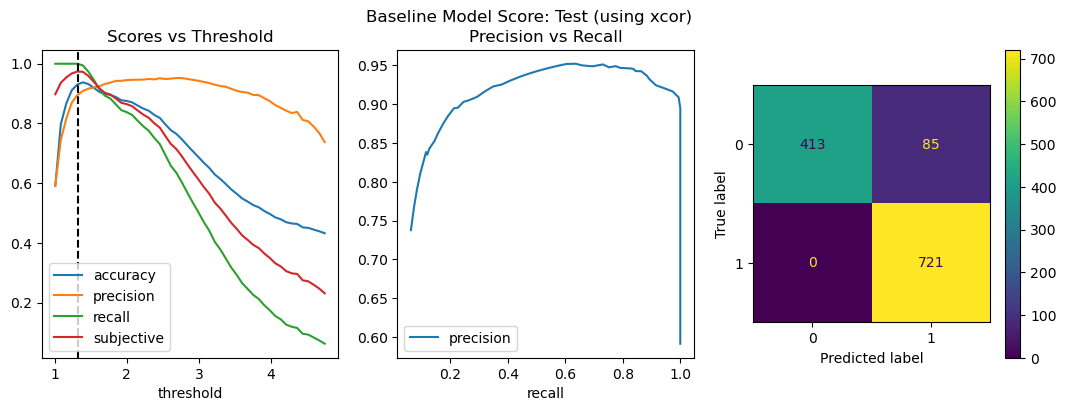

In [77]:
run_baseline(baseline_template, X_train, y_train, X_test, y_test, similarity_strat='xcor')

# Feature Engineering



TODO: Include AUC of ROC